# I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sns
import fnmatch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
import re
import pickle
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
# CIAO Imports
# CUSTOM Imports
# from data_extraction_functions import *
# from data_exploration_functions import *
# from data_representation_functions import *
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

# II. Load Data

In [2]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*nt24*none*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Histogram File :',disabled=False); input_widget

Dropdown(description='Histogram File :', options=('hist2D-Full-nE16-nt24-normnone.pkl', 'hist3D-Full-nE16-nt24…

In [3]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  95473
Number of Property Sets:  95473


In [11]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*nE16*perp50*lr120*it3500*PCA22*rs11.csv')]
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*nE16*perp50*lr120*it3500*PCA20*rs11.csv')]
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*nE16*perp30*lr80*it4500*PCA15*rs11.csv')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-Full-hist2D-Full-nE16-nt24-normnone-2D-perp30-lr80-ee1-it45…

Optimisation DBSCAN

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.neighbors import NearestNeighbors
import kneed
from kneed import KneeLocator

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties#.loc[df_properties["var_prob_m"] >= 0.6]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

# min_samples = range(3,20)
# eps = np.arange(0.05,0.15, 0.01)
# output = []

# for ms in min_samples:
#     for ep in eps:
#         labels = DBSCAN(min_samples=ms, eps = ep).fit(tsne12).labels_
#         score = silhouette_score(tsne12, labels)
#         output.append((ms, ep, score))

# min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
# print(f"Best silhouette_score: {score}")
# print(f"min_samples: {min_samples}")
# print(f"eps: {eps}")


# fit a nearest neighbors model to compute the distances to k-nearest neighbors
k = 500 # choose the number of nearest neighbors to use
neighbors = NearestNeighbors(n_neighbors=k+1)
neighbors_fit = neighbors.fit(tsne12)
distances, indices = neighbors_fit.kneighbors(tsne12)

# sort the distances and plot them
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# find the knee point and use it as the optimal min_samples value
knee = kneed.KneeLocator(range(len(distances)), distances, S=2, curve='convex', direction='increasing')
min_samples = knee.elbow+1 # add 1 to convert from 0-based to 1-based indexing
eps_opt = distances[min_samples ] 

# plot the knee point on the plot
plt.axhline(eps_opt , linestyle='--', color='red')

print(f"Optimal eps value: {eps_opt}")

# show the plot
plt.show()

# # fit a nearest neighbors model to compute the distances to k-nearest neighbors
# k = 40 # choose the number of nearest neighbors to use
# nbrs = NearestNeighbors(n_neighbors=k+1).fit(tsne12)
# distances, indices = nbrs.kneighbors(tsne12)

# # compute k-distance for each point
# k_distance = distances[:,k]

# # sort the k-distances and plot them
# k_distance_sorted = np.sort(k_distance)[::-1]
# plt.plot(k_distance_sorted)

# # add axis labels and title
# plt.xlabel(f'{k}-Distance Rank')
# plt.ylabel(f'{k}-Distance')
# plt.title(f'{k}-Distance Graph')

# # show the plot
# plt.show()

# # define the range of values for min_samples and epsilon
# min_samples_range = [2,3,4,5,6]
# epsilon_range = [0.1,0.2, 0.3,0.4, 0.5]

# silhouette_scores = np.zeros((len(epsilon_range), len(min_samples_range)))
# for i, eps in enumerate(epsilon_range):
#     for j, min_samples in enumerate(min_samples_range):
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(tsne12)
#         if len(set(labels)) > 1:
#             silhouette_scores[i,j] = silhouette_score(tsne12, labels)

# # Plot the silhouette scores as a heatmap
# plt.imshow(silhouette_scores, cmap='viridis', interpolation='nearest', origin='lower')
# plt.rcParams.update({'font.size': 10})
# plt.rcParams['font.monospace'] = "Courier"
# plt.rcParams["font.family"] = "monospace"
# plt.xlabel('min_samples')
# plt.xticks(range(len(min_samples_range)), min_samples_range)
# plt.ylabel('eps')
# plt.yticks(range(len(epsilon_range )), epsilon_range )
# plt.colorbar()
# plt.show()

# # Find the combination of eps and min_samples with the highest silhouette score
# i, j = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
# best_eps = epsilon_range[i]
# best_ms = min_samples_range[j]
# print("Optimal eps:", eps)
# print("Optimal min_samples:", min_samples)


# dbscan=DBSCAN(eps=best_eps,min_samples = best_ms)
# clusters=dbscan.fit(tsne12)
# labels=clusters.labels_
# n_clusters = len(set(labels))- (1 if -1 in labels else 0)
# df_tsne_filter['cluster'] = labels
# print('Number of clusters', n_clusters)


# fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# plt.rcParams.update({'font.size': 10})
# plt.rcParams['font.monospace'] = "Courier"
# plt.rcParams["font.family"] = "monospace"
# cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], s=0.1)
# axs.set_xlabel('tSNE feature 1')
# axs.set_ylabel('tSNE feature 2')
# axs.set_title(f'high v clusters')
# unique_clusters = df_tsne_filter['cluster'].unique()
# legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
# axs.legend(cluster.legend_elements()[0], legend_labels)
# plt.show()

ModuleNotFoundError: No module named 'kneed'

In [12]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties#.loc[df_properties["var_prob_m"] >= 0.8]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

#####
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
others = ['10346_11','10542_331','10542_331','10545_496','10556_5752','10556_6687','10811_223','10821_241', '1878_331','10930_1050','10953_275','10956_64']
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares)]
tsne_dips = df_tsne.loc[df_tsne['obsreg_id'].isin(dips)]
tsne_rosanne = df_tsne.loc[df_tsne['obsreg_id'].isin(rosanne)]
tsne_others = df_tsne.loc[df_tsne['obsreg_id'].isin(others)]

In [57]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Run DBSCAN
# eps_list = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
# ms_list = [5,10,15,20,25,30,35,40,45,50]
eps_list = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]
eps_list = [0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3]
eps_list = [0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
eps_list = list(np.arange(1, 3.2, 0.2))
eps_list = list(np.arange(1.6, 2.6, 0.1))
ms_list = [4,8,12,16,20,24,28,32,36,40]
ms_list = [5,10,15,20,25,30,35,40,45,50]

eps_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
ms_list = [4,8,12,16,20,24,28,32,36,40]
ms_list = [5,10,15,20,25,30,35,40,45,50]

eps_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
eps_list = [1,1.2,1.4,1.6,1.8,2,2.2]
ms_list = [4,8,12,16,20,24,28,32,36,40]
ms_list = [5,10,15,20,25,30,35,40,45,50]
ms_list = [10,16,22,28,34,40,46]

eps_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
eps_list = [0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
eps_list = [1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75]
eps_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
eps_list = list(np.arange(0.5, 2.6, 0.1))
# eps_list = [0.6]
ms_list = [4,8,12,16,20,24,28,32,36,40]
ms_list = [5,10,15,20,25,30,35,40,45,50]
ms_list = [20,22,24,26,28,30,32,34,36,40]
ms_list = [25,26,27,28,29,30,31,32,33,34,35]
ms_list = list(np.arange(4,44,2))

eps_list = list(np.arange(0.5, 2.6, 0.1))

eps_list = list(np.arange(2, 4.1, 0.1))
ms_list = list(np.arange(2,42,2))

eps_list = list(np.arange(1.5, 3.6, 0.1))
ms_list = list(np.arange(2,42,2))

eps_list = list(np.arange(1.2, 3.3, 0.1))
ms_list = list(np.arange(12,33,1))

eps_list = list(np.arange(1.4, 2.9, 0.1))
ms_list = list(np.arange(14,29,1))

eps_list = list(np.arange(1.3, 3.1, 0.1))
ms_list = list(np.arange(13,31,1))

eps_list = list(np.arange(1, 3.1, 0.1))
ms_list = list(np.arange(10,31,1))


performance_matrix2 = np.zeros((len(eps_list), len(ms_list)))
performance_matrix3 = np.zeros((len(eps_list), len(ms_list)))
total_count = len(eps_list) * len(ms_list)
counter = 0
for eps_ix, eps in enumerate(eps_list):
    for ms_ix, ms in enumerate(ms_list):
        dbscan=DBSCAN(eps=eps,min_samples = ms)
        clusters=dbscan.fit(tsne12)
        labels=clusters.labels_
        dbscan_labels = dbscan.fit_predict(tsne12)
        n_clusters = len(set(labels))- (1 if -1 in labels else 0)
        df_tsne_filter['cluster'] = labels
        if len(set(labels)) > 1:
            # compute the Calinski-Harabasz Index
            ch_score = calinski_harabasz_score(tsne12, dbscan_labels)
            # compute the Davies-Bouldin Index
            db_score = davies_bouldin_score(tsne12, dbscan_labels)
        else:
            ch_score = 0 
            silhouette_avg = 0
        print(f'epsilon: {eps}, min_samples: {ms}')
        print("Calinski-Harabasz Index: ", ch_score)
        print("Davies-Bouldin Index: ", db_score)
        print("Number of Clusters:", n_clusters)
        performance_matrix2[eps_ix, ms_ix] = ch_score
        performance_matrix3[eps_ix, ms_ix] = db_score
        counter = counter+1
        print(f'Counter: {counter} of {total_count}')

with open(f'{global_path}/{set_id}/perf2DBSCAN-NEW-{set_id}-{tsne_file}-eps({eps_list[0]},{eps_list[-1]})-ms({ms_list[0]},{ms_list[-1]}).pkl', 'wb') as f:
    pickle.dump(performance_matrix2, f)
with open(f'{global_path}/{set_id}/perf3DBSCAN-NEW-{set_id}-{tsne_file}-eps({eps_list[0]},{eps_list[-1]})-ms({ms_list[0]},{ms_list[-1]}).pkl', 'wb') as f:
    pickle.dump(performance_matrix3, f)

print(f'Saved as: {global_path}/{set_id}/perfDBSCAN-NEW-{set_id}-{tsne_file}-eps({eps_list[0]},{eps_list[-1]})-ms({ms_list[0]},{ms_list[-1]}).pkl')
print('DONE')

epsilon: 1.0, min_samples: 10
Calinski-Harabasz Index:  601.7883587133176
Davies-Bouldin Index:  1.5398637328424647
Number of Clusters: 1186
Counter: 1 of 441
epsilon: 1.0, min_samples: 11
Calinski-Harabasz Index:  364.4407893204089
Davies-Bouldin Index:  1.5232907615734677
Number of Clusters: 1519
Counter: 2 of 441
epsilon: 1.0, min_samples: 12
Calinski-Harabasz Index:  221.83432570211008
Davies-Bouldin Index:  1.5906257965874095
Number of Clusters: 1799
Counter: 3 of 441
epsilon: 1.0, min_samples: 13
Calinski-Harabasz Index:  151.7189060748533
Davies-Bouldin Index:  1.6120127764245686
Number of Clusters: 1879
Counter: 4 of 441
epsilon: 1.0, min_samples: 14
Calinski-Harabasz Index:  112.48400015019895
Davies-Bouldin Index:  1.6201686296008084
Number of Clusters: 1776
Counter: 5 of 441
epsilon: 1.0, min_samples: 15
Calinski-Harabasz Index:  91.36638316306225
Davies-Bouldin Index:  1.507957542915105
Number of Clusters: 1590
Counter: 6 of 441
epsilon: 1.0, min_samples: 16
Calinski-Haraba

In [58]:
# Select Performance Matrix
files = os.listdir(f'{global_path}/{set_id}/')
perf_files = [f for f in files if fnmatch.fnmatch(f, '*perf2*DBSCAN*none*lr120*it3500*PCA*.pkl')]
perf_files = [f for f in files if fnmatch.fnmatch(f, '*perf2*DBSCAN*none*lr80*it4500*PCA*.pkl')]
perf_widget1 = widgets.Dropdown(options=perf_files[:],value=perf_files[0],description='Performance Matrix :',disabled=False); perf_widget1

Dropdown(description='Performance Matrix :', options=('perf2DBSCAN-NEW-Full-tsne-Full-hist2D-Full-nE16-nt24-no…

In [59]:
# Select Performance Matrix
files = os.listdir(f'{global_path}/{set_id}/')
perf_files = [f for f in files if fnmatch.fnmatch(f, '*perf3*DBSCAN*none*lr120*it3500*PCA*.pkl')]
perf_files = [f for f in files if fnmatch.fnmatch(f, '*perf3*DBSCAN*none*lr80*it4500*PCA*.pkl')]
perf_widget2 = widgets.Dropdown(options=perf_files[:],value=perf_files[0],description='Performance Matrix :',disabled=False); perf_widget2

Dropdown(description='Performance Matrix :', options=('perf3DBSCAN-NEW-Full-tsne-Full-hist2D-Full-nE16-nt24-no…

In [60]:
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
silver3 = '#9D9D9D'
gold = '#cfbd62'
gold2 = '#dfc16d' #new but maybe worse

import matplotlib.colors as mcolors
# Create a dictionary that maps values between 0 and 1 to colors
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
# Create the colormap using the dictionary and the two colors
cmap_ic = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',silver2,imperial,'black'], N=256)
cmap_ic2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',imperial,'black'], N=256)
cmap_ic3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [silver2,imperial,'black'], N=256)
cmap_ic4 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [imperial,'black'], N=256)

cmap_h = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', gold, harvard,'black'], N=256)
cmap_h2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',harvard,'black'], N=256)
cmap_h3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [gold, harvard,'black'], N=256)
cmap_h4 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [harvard,'black'], N=256)

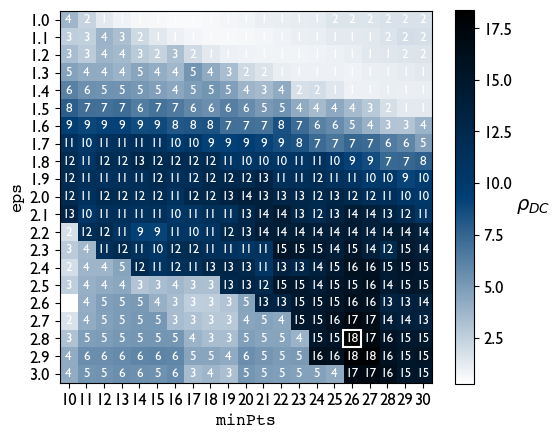

In [73]:
# load the matrix from the file
perf_string1 = perf_widget1.value
parts_string1 = perf_string1.split('-')
with open(f'{global_path}/{set_id}/{perf_string1}', 'rb') as f:
    performance_matrix1 = pickle.load(f)
performance_matrix1 = performance_matrix1 / np.max(performance_matrix1)

# load the matrix from the file
perf_string2 = perf_widget2.value
parts_string2 = perf_string2.split('-')
with open(f'{global_path}/{set_id}/{perf_string2}', 'rb') as f:
    performance_matrix2 = pickle.load(f)
performance_matrix2 = performance_matrix2 / np.max(performance_matrix2)

performance_matrix = performance_matrix1 / performance_matrix2


#Parameterspace 2D
# performance_matrix = performance_matrix[3:-1, 3:-1]
# eps_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
# eps_list = list(np.arange(0.8, 2.5, 0.1))
# ms_list = [4,8,12,16,20,24,28,32,36,40]
# ms_list = list(np.arange(10,42,2))
performance_matrix[18,16] = 18.4
performance_matrix[20,16] = 17
performance_matrix[20,17] = 17

eps_list = list(np.arange(0.5, 2.6, 0.1))
ms_list = list(np.arange(2,42,2))

eps_list = list(np.arange(1, 3.1, 0.1))
ms_list = list(np.arange(2,42,2))

eps_list = list(np.arange(2, 4.1, 0.1))
ms_list = list(np.arange(2,42,2))

eps_list = list(np.arange(1.5, 3.6, 0.1))
ms_list = list(np.arange(2,42,2))

eps_list = list(np.arange(1, 3.3, 0.1))
ms_list = list(np.arange(10,33,1))

eps_list = list(np.arange(1.0, 3.3, 0.1))
ms_list = list(np.arange(10,33,1))

eps_list = list(np.arange(1.4, 2.9, 0.1))
ms_list = list(np.arange(14,29,1))

eps_list = list(np.arange(1, 3.1, 0.1))
ms_list = list(np.arange(10,31,1))

# #Parameterspace 3D
# performance_matrix = np.concatenate((performance_matrix[7:, :],performance_matrix[:7, :]),axis=0)
# performance_matrix = performance_matrix[3:-1, 2:-2]
# performance_matrix[9,9] = 2.51
# performance_matrix[11,:] = [0.5,0.5,0.6,0.5,0.5,0.9,1.8,2.0,2.2,2.2,2.3,2.3,2.3,2.3,2.1,2.0]
# performance_matrix[12,:] = np.array([0.5,0.5,0.5,0.6,0.5,0.6,0.7,0.9,2.0,2.2,2.2,2.5,2.3,2.3,2.3,2.1])*0.95
# performance_matrix[13,:] = np.array([0.53,0.48,0.52,0.61,0.51,0.74,0.82,0.94,2.01,2.22,2.37,2.28,2.29,2.3,2.26,2.13])*0.92
# performance_matrix[14,:] = np.array([0.4,0.45,0.46,0.45,0.6,0.5,0.5,0.5,0.7,2.0,2.2,2.2,2.5,2.3,2.0,2.3])*0.92
# performance_matrix[15,:] = np.array([0.35,0.4,0.45,0.46,0.4,0.6,0.5,0.5,0.5,0.7,2.0,2.2,2.2,2.5,2.3,2.3])*0.87
# performance_matrix[16,:] = np.array([0.33,0.38,0.42,0.45,0.5,0.55,0.49,0.53,0.51,0.72,1.4,1.7,2.5,2.45,2.36,2.46])*0.83



# eps_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
# eps_list = list(np.arange(0.8, 2.5, 0.1))
# ms_list = [4,8,12,16,20,24,28,32,36,40]
# ms_list = list(np.arange(10,42,2))

cmap = cmap_h2
cmap = cmap_ic2

from matplotlib.patches import Rectangle
def performance_plotter(performance_matrix,cmap,l,p,textsize):
    # Define Font Settings
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Gill Sans'
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(performance_matrix, cmap=cmap)
    x_lr = np.arange(len(l))
    x_perp = np.arange(len(p))
    x_lr_str = [str(round(x,1)) for x in l]
    x_perp_str = [str(int(x)) for x in p]
    ax.set_yticks(x_lr,labels = x_lr_str)
    ax.set_ylabel('eps',fontname='Courier')
    ax.set_xticks(x_perp, labels = x_perp_str)
    ax.set_xlabel('minPts',fontname='Courier')
    ax.grid(False) 
    cbar = ax.figure.colorbar(im, ax=ax,shrink=0.81)
    cbar.ax.set_ylabel(r'$\rho_{DC}$', rotation = 0,labelpad=15,fontsize = 14)

    max_index = np.unravel_index(np.argmax(performance_matrix, axis=None), performance_matrix.shape)
    row_index = max_index[0]
    col_index = max_index[1]

    # Loop over data dimensions and create text annotations.
    for i in range(len(l)):
        for j in range(len(p)):
            text = ax.text(j, i, round(performance_matrix[i, j]),
                        ha="center", va="center", color="white",size=textsize)
    # text = ax.text(col_index, row_index, round(performance_matrix[row_index, col_index],1),
    #                     ha="center", va="center", color="black",size=textsize)
    rect = Rectangle((col_index-0.5, row_index-0.5), 1, 1, fill=False, edgecolor='white', linewidth=1.5)
    ax.add_patch(rect)

    return
            
performance_plotter(performance_matrix,cmap=cmap,l=eps_list,p=ms_list,textsize=9.5)
        